# Delaware Case Study
## Simple Model of SGD



In [121]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport SGD,utils
import os
from pathlib import Path
import sys
import numpy as np
import numpy.matlib as matlib
import matplotlib.pyplot as plt
import matplotlib.colors
import warnings
import scipy.stats as sts
#Name model
modelname = 'homogenous'

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
import SGD

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('flopy version: {}'.format(flopy.__version__))

if sys.platform == "darwin":
    model_ws = os.path.join('/Users/ianpg/Documents/ProjectsLocal/DelawareSGD','work',modelname)
elif sys.platform == "win32":
    model_ws = os.path.join('E:\Projects\DelawareSGD','work',modelname)

if not os.path.exists(model_ws):
    os.makedirs(model_ws)
sys.path.append(os.path.join(model_ws,'..','..'))
import config
sw_exe = config.swexe #set the exe path for seawat
print('Model workspace:', os.path.abspath(model_ws))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 09:55:02) 
[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]
numpy version: 1.13.1
flopy version: 3.2.10
Model workspace: /Users/ianpg/Documents/ProjectsLocal/DelawareSGD/work/homogenous


### Utility functions


In [122]:
#nearest value in array
def find_nearest(array,value):
    import numpy as np
    idx = (np.abs(array-value)).argmin()
    idx.astype('int')
    return array[idx]

#take distance in meters, return column in model
def loc_to_col(locs):
    cols = [int(find_nearest((np.arange(ncol)*delc),loc)) for loc in locs]
    return cols

#make a line across the grid
def get_line(start, end,allrows=1,nrow=None):
    """Bresenham's Line Algorithm
    Produces a list of tuples from start and end
 
    >>> points1 = get_line((0, 0), (3, 4))
    >>> points2 = get_line((3, 4), (0, 0))
    >>> assert(set(points1) == set(points2))
    >>> print points1
    [(0, 0), (1, 1), (1, 2), (2, 3), (3, 4)]
    >>> print points2
    [(3, 4), (2, 3), (1, 2), (1, 1), (0, 0)]
    """
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1
 
    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)
 
    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
 
    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True
 
    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1
 
    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1
 
    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        if allrows==1:
            if nrow is None:
                nrow = m.nrow
            for row in range(nrow):
                coord = (y, row, x) if is_steep else (x, row, y)
                points.append(coord)
        else:
            coord = (y, x) if is_steep else (x, y)
            points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx
 
    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
    return points


#make all cells=0 above the line from get_line()
#Calculate freshwater head based on column of saltwater above each node (rho*g*z)
def shade_above(nlay,nrow,ncol,point_list,third_dim=1):
    import numpy as np
    grd = np.ones((nlay,nrow,ncol),dtype='int')
    ocean_hf = []
    if len(point_list)==0:
        return grd,ocean_hf
    for (lay,row,col) in point_list:
        grd[lay,:,col] = -1 #assign ocean ibound to -1
        grd[:lay,:,col] = 0 #assign cells above ocean to 0
        hf = densefresh/densesalt*ocean_elev - (densesalt - densefresh)/densefresh*(henry_botm[lay] +.5*delv)
        for irow in range(nrow):
            ocean_hf.append((int(lay),int(irow),int(col),hf))
    ocean_hf = tuple(np.array(ocean_hf).T)
    ocean_hf = (ocean_hf[0].astype('int'),
                ocean_hf[1].astype('int'),
                ocean_hf[2].astype('int'),
                ocean_hf[3])
    return grd,ocean_hf

def get_ocean_right_edge(m,ocean_line_tuple):
    import numpy as np
    point_list = []
    
    #If there is no vertical side boundary, return bottom-right corner node
    if len(ocean_line_tuple)==0:
        startlay = 0
    elif max(ocean_line_tuple[0])==m.nlay:
        startlay = m.nlay
    elif max(ocean_line_tuple[0])<m.nlay:
        startlay = max(ocean_line_tuple[0])
    for lay in range(startlay,m.nlay):
        for row in range(m.nrow):
            point_list.append((lay,row,m.ncol-1))
    point_list = tuple(np.array(point_list).T)
    return point_list

#create random clay blocks throughout model (quick dirty way to do heterogeneity)
def rand_clay_blocks(lithmat,hkClay,numblocks,sizeblocks):
    nlay,nrow,ncol = lithmat.shape
    lay_block = np.random.randint(1,nlay-sizeblocks[0],numblocks)
    row_block = np.random.randint(0,nrow-sizeblocks[1]+1,numblocks)
    col_block = np.random.randint(1,ncol-sizeblocks[2],numblocks)
    lithmat_blocks = lithmat.copy()
    for i in range(numblocks):
        block_coords = [slice(lay_block[i],lay_block[i]+sizeblocks[0]),
                        slice(row_block[i],row_block[i]+sizeblocks[1]),
                        slice(col_block[i],col_block[i]+sizeblocks[2])]
        lithmat_blocks[block_coords] = hkClay
    return lithmat_blocks

In [163]:
#Model grid
#Grid: 0.5 *1*1m • Size:70m*20m

Lx = 3000.
Ly = 1000.
Lz = 80.

Lx = 3000.
Ly = 600.
Lz = 80.

xul=488930.5-3 #minimum x value - 3
yul=4271464.0-32 #minimum y value -32 to place in front of breakwater
rotation=0
nlay = int(Lz*1/5)
nrow = int(Ly*(1/50))
ncol = int(Lx*(1/50))
delr = Lx / ncol
delc = Ly / nrow
delv = Lz / nlay

beachslope = .05
henry_top = 0
henry_botm = np.linspace(henry_top - delv, henry_top - Lz, nlay)

##dev
#Create ocean boundary at top of model
ocean_col = [np.floor(ncol-1).astype('int'),ncol-1] #Manually done to make sure it's in the right place rn

ocean_elev = 0
inland_elev = beachslope*ocean_col[0]*delr
offshore_elev = -beachslope*(ocean_col[1]-ocean_col[0])*delr

#beach_arr = matlib.repmat(np.linspace(inland_elev,offshore_elev,num=ncol),nrow,1)
#henry_top = ocean_elev*np.ones((nrow,ncol), dtype=np.float) + beach_arr
#henry_botm = matlib.repmat(np.linspace(ocean_elev - delv, ocean_elev - Lz, nlay),ncol,1).transpose() + beach_arr[1]
#henry_botm = np.transpose(np.tile(henry_botm,(nrow,1,1)),
#                          (1,0,2))
##dev


#Period data
perlen = [100,100,15000]
nstp = [5,5,5]

Lt = 360*20 #Length of time in days
perlen = list(np.repeat(180,int(Lt/180)))
nstp = list(np.ones(np.shape(perlen),dtype=int))

nper = len(perlen)
steady = [False for x in range(len(perlen))] #Never steady
itmuni = 4 #time unit 4= days
lenuni = 2 #length unit 2 = meter
tsmult = 1.8
ssm_data = None
verbose = True

In [146]:
#Create basic model instance and dis pacakge
m = flopy.seawat.Seawat(modelname, exe_name=sw_exe, model_ws=model_ws,verbose=verbose)
SGD.ModelSGD.Seawat2SGD(m)  #convert to subclass ModelSGD
print(m.namefile)

# Add DIS package to the MODFLOW model
dis = flopy.modflow.ModflowDis(m, nlay, nrow, ncol, nper=nper, delr=delr,
                               delc=delc, xul=xul, yul=yul, rotation=rotation,
                               laycbd=0, top=henry_top,
                               botm=henry_botm, perlen=perlen, nstp=nstp,
                               steady=steady,itmuni=itmuni,lenuni=lenuni,
                               tsmult=tsmult)

homogenous.nam
adding Package:  DIS


In [147]:
#Hydraulic conductivity field 
hkSand = 80.  #horizontal hydraulic conductivity m/day
hkClay = 1. 
lithmat = hkSand*np.ones((nlay,nrow,ncol), dtype=np.int32) #sandy background
addclay_yn = 0

#add random low conductivity regions
if addclay_yn == 1:
    lithmat = rand_clay_blocks(lithmat,hkClay,100,(2,1,5))

#Set Hydraulic properties

hk = lithmat
sy = 0.15
ss = 0.00005
por = 0.2
vka = 1/10 # = vk/hk
al = 10 #longitudinal dispersivity (m) from Walther et al. 2017
dmcoef = 2e-9 #m2/day  from Walther et al. 2017
#dmcoef = 1.62925 #is a case of the Henry problem

#### FOR TESTING
#al = 0
#dmcoef = 0. #test for numerical dispersion
#### FOR TESTING

#Variable density parameters
Csalt = 35.0001
Cfresh = 0.
densesalt = 1025.
densefresh = 1000.
denseslp = (densesalt - densefresh) / (Csalt - Cfresh)
#denseslp = 0 #trick for testing constant density

In [148]:
def add_pumping_wells(wel_data,ssm_data,n_wells,flx,rowcol,kper):
    itype = flopy.mt3d.Mt3dSsm.itype_dict()
    new_weldata = wel_data
    new_ssmdata = ssm_data
    for k in range(n_wells):
        row,col = rowcol[k]
        for i in range(nper):
            if i in kper:
                for j in range(nlay):
                    #WEL {stress_period: [lay,row,col,flux]}
                    new_weldata[i].append([j,row,col,-flx[k]/(nlay)])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    new_ssmdata[i].append([j,row,col,Cfresh,itype['WEL']]) #since it's a sink, conc. doesn't matter
            else:
                for j in range(nlay):
                    #WEL {stress_period: [lay,row,col,flux]}
                    new_weldata[i].append([j,row,col,0])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    new_ssmdata[i].append([j,row,col,Cfresh,itype['WEL']]) #since it's a sink, conc. doesn't matter
                continue
    return new_weldata, new_ssmdata

In [149]:
'''
def add_pumping_wells(wel_data,ssm_data,n_wells,flx_generator,rowcol,*args):
    itype = flopy.mt3d.Mt3dSsm.itype_dict()
    new_weldata = wel_data
    new_ssmdata = ssm_data
    flx = []
    for k in range(n_wells):
        row,col = rowcol[k]
        flx.append(flx_generator(*args))
        for i in range(nper):
                for j in range(nlay):
                    #WEL {stress_period: [lay,row,col,flux]}
                    new_weldata[i].append([j,row,col,-flx[k]/(nlay)])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    new_ssmdata[i].append([j,row,col,Cfresh,itype['WEL']]) #since it's a sink, conc. doesn't matter
    return new_weldata, new_ssmdata,flx
   
'''
#Add recharge if desired
def make_rech_array(low=1e-2,high=1e0):
    import scipy.stats as sts
    llow,lhigh = np.log10((low,high))
    rech = np.exp(sts.uniform.rvs(size=1,loc=llow,scale=lhigh-llow)[0])
    return rech/(nrow*ncol)

def add_recharge_cells(recharge_generator,const=1,*args):
    if const==1:
        rech_data = recharge_generator(*args)
    else:
        rech_data = {}
        for i in range(nper):
            rech_array = recharge_generator(*args)
        rech_data[i] = rech_array
    return rech_data

def sample_dist(distclass,size,writeyn=0,model=None,varname=None,log_backtransf=0,*args):
    smp = distclass.rvs(*args,size=size)
    if log_backtransf==1:
        smp = tuple([10**x for x in smp])
    if size==1:
        smp=smp[-1]
    if writeyn==1:
        write_sample(model.MC_file,varname,distclass,smp)
    return smp

def write_sample(fname,varname,distclass,sample):
    fout= open(fname,"a")
    fout.write(varname + ',' + str(type(distclass)) + ',' + str(sample) + '\n')
    fout.close()
    return

In [150]:
#BCs
bc_ocean = 'GHB'
bc_right_edge = 'GHB'
bc_inland = 'WEL'
add_wells = 1
n_wells = 2
rech_on = 1

#BC values 
#Inland
calc_inland_head = 0 #calculate from hgrad
#manual_inland_head = henry_top + .1
manual_inland_head = .75
#influx = hkSand*delr*delv*hgrad*nlay #m^3/day through inland boundary
influx = 1.41e-7 *(delc*nrow)*(delv*nlay) #from Walther et. al 2017
#influx = 0.015*(delc*nrow)*(delv*nlay)

start_fresh_yn = 1

ocean_shead = [ocean_elev for x in range(len(perlen))] 
ocean_ehead = ocean_shead

# save cell fluxes to unit 53
ipakcb = 53

#MODFLOW BCs
hgrad = 0.0033 #hydraulic gradient, m/m
qinflow = 0  #influent FW m3/day

#Create ocean boundary at top of model
ocean_col_vec = (0,0,np.arange(ocean_col[0],ocean_col[1]+1))
ocean_coords = (0,slice(0,nrow),slice(ocean_col[0],ocean_col[1]+1)) #top of the model
ocean_bool = np.zeros((nlay,nrow,ncol), dtype=bool)
ocean_bool[0,:,np.arange(ocean_col[0],ocean_col[1]+1)] = 1
m.ocean_arr = ocean_bool


if calc_inland_head == 1:
    head_inland = ocean_col[0]*delc*hgrad + ocean_elev
else:
    head_inland = manual_inland_head

####IN TESTING#####
#Create a line of where the ocean is, and any nodes on right edge below ocean
offshore_lay = (np.abs(henry_botm-offshore_elev)).argmin().astype('int')
if ocean_col[0] == ncol-1:
    ocean_line = []
    bc_ocean = 'XXX'
else:
    ocean_line = get_line((0,ocean_col[0]),(offshore_lay,ocean_col[1]),allrows=1,nrow=1)

ocean_line_tuple = tuple(np.array(ocean_line).T) #use this for indexing numpy arrays
right_edge = get_ocean_right_edge(m,ocean_line_tuple)

#Create ibound
ibound,ocean_hf = shade_above(nlay,nrow,ncol,ocean_line) #don't set ibound of ocean
#ibound = np.ones((nlay,nrow,ncol),dtype=np.int)
if bc_ocean == 'GHB':
    ibound[ocean_line_tuple]=1
#ibound[:, :, 0] = -1 #first column (FW boundary) has fixed head
#ibound[0:1,:,ocean_col[0]-3:ocean_col[0]] = 0 #small block before beach is no-flow

if bc_right_edge =='CHD':
    ibound[right_edge] = -1


#Set starting heads
strt = ocean_elev*np.ones((nlay, nrow, ncol),dtype='float') #starting heads

if bc_inland=='CHD':
    strt[:,:,0] = head_inland #head inland
if len(ocean_hf)>0:
    strt[ocean_hf[0],
        ocean_hf[1],
        ocean_hf[2]] = ocean_hf[3] #self-calculate equivalent FW head; this is repeated in CHD/GHB package
    right_edge_hf = ocean_hf[3][-1] - (densesalt - densefresh)/densefresh*(henry_botm[right_edge[0]] +.5*delv)
else:
    right_edge_hf = -(densesalt - densefresh)/densefresh*(henry_botm[right_edge[0]] +.5*delv)

strt[right_edge] = right_edge_hf
#strt[right_edge] = ocean_hf[3][-1] #set right (ocean) edge below the sloped boundary
#strt[ocean_hf[0][-1] +1:,:,-1] = ocean_hf[3][-1]
strt = np.zeros((nlay,nrow,ncol),dtype=np.int)


#Transport BCs
if start_fresh_yn == 1:
    sconc = Cfresh*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin fresh
elif start_fresh_yn == 0:
    sconc = Csalt*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin SW-saturated
else:
    sconc = Cfresh*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin SW-saturated
    sconc[:,:,int(np.floor(ncol/2)):-1] = Csalt

if ocean_hf:
    sconc[ocean_hf[0:3]] = Csalt
sconc[:,:,-1] = Csalt
sconc[:,:,0] = Cfresh

icbund = np.ones((nlay, nrow, ncol), dtype=np.int) 
### If using SSM, I think we don't need to hold cells as constant concentration
#icbund[(ibound < 0)] = -1 #constant concentration cells where also constant head
#icbund[:,:,0] = -1 #right now hold inland boundary to constant concentration
icbund[np.where(ibound==-1)] = -1

def make_bc_dicts():
    #Ocean and inland boundary types
    itype = flopy.mt3d.Mt3dSsm.itype_dict()
    chd_data = {}
    ssm_data = {}
    ghb_data = {}
    wel_data = {}
    for i in range(nper):
        dat_chd = []
        dat_ssm = []
        dat_ghb = []
        dat_wel = []
        #Ocean boundary
        if ocean_hf:
            for j in range(np.size(ocean_hf[0])):
                if bc_ocean=='CHD':
                    #CHD: {stress_period: [lay,row,col,starthead,endhead]}
                    dat_chd.append([ocean_line_tuple[0][j],
                                ocean_line_tuple[1][j],
                                ocean_line_tuple[2][j],
                                ocean_shead[i],
                                ocean_ehead[i]])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    dat_ssm.append([ocean_line_tuple[0][j],
                                ocean_line_tuple[1][j],
                                ocean_line_tuple[2][j],
                                Csalt,
                                itype['CHD']])
                elif bc_ocean=='GHB':
                    #GHB: {stress period: [lay,row,col,head level,conductance]}
                    #conductance c = K*A/dL; assume horizontal flow at outlet,
                    #and calculate length to be at edge of ocean cell, as opposed to mipoint
                    # c = (K*dy*dz)/(dx/2) = 2*K*delr*delv/delc
                    dat_ghb.append([ocean_hf[0][j],
                                   ocean_hf[1][j],
                                   ocean_hf[2][j],
                                   #ocean_hf[3][j],
                                    ocean_elev-henry_top,
                                   2*hkSand*delc*delv/delr])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    dat_ssm.append([ocean_hf[0][j],
                                   ocean_hf[1][j],
                                   ocean_hf[2][j],
                                   Csalt,
                                   itype['GHB']])
        else:
            pass
        #Right edge boundary
        if bc_right_edge=='GHB':
            for j in range(np.size(right_edge[0])):
                #GHB: {stress period: [lay,row,col,head level,conductance]}
                #conductance c = K*A/dL; assume horizontal flow at outlet,
                #and calculate length to be at edge of ocean cell, as opposed to mipoint
                # c = (K*dy*dz)/(dx/2) = 2*K*delr*delv/delc
                dat_ghb.append([right_edge[0][j],
                               right_edge[1][j],
                               right_edge[2][j],
                               #ocean_hf[3][j],
                                ocean_elev-henry_top,
                               2*hkSand*delc*delv/delr])
                #SSM: {stress_period: [lay,row,col,concentration,itype]}
                dat_ssm.append([right_edge[0][j],
                               right_edge[1][j],
                               right_edge[2][j],
                               Csalt,
                               itype['GHB']])
        else:
            pass
        #Inland boundary
        if bc_inland=='GHB':
            for j in range(nlay):
                for k in range(nrow):
                    #GHB: {stress period: [lay,row,col,head level,conductance]}
                    dat_ghb.append([j,k,0,head_inland,
                                    2*hkSand*delc*delv/delr])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    dat_ssm.append([j,k,0,Cfresh,itype['GHB']])
        elif bc_inland=='WEL':
            for j in range(nlay):
                for k in range(nrow):
                    #WEL: {stress_period: [lay,row,col,flux]}
                    dat_wel.append([j,k,0,influx/(nlay*nrow)])
                    #SSM: {stress_period: [lay,row,col,concentration,itype]}
                    dat_ssm.append([j,k,0,Cfresh,itype['WEL']])
        chd_data[i] = dat_chd
        ssm_data[i] = dat_ssm
        ghb_data[i] = dat_ghb
        wel_data[i] = dat_wel

    #saving concentrations at specified times
    #timprs = [k for k in range(1,np.sum(perlen),50)]
    return chd_data, ssm_data, ghb_data, wel_data

chd_data, ssm_data, ghb_data, wel_data = make_bc_dicts()
wel_data_base,ssm_data_base = wel_data,ssm_data
timprs = np.round(np.linspace(1,np.sum(perlen),20),decimals=0)

In [151]:
#### ADD WELL AND RECHARRGE DATA####
#Winter is even stress periods, summer is odd SP.
#Winter= wells OFF, natural precip (rech) ON, irrigation rech OFF, 
#Summer = wells ON, irrigation rech (farm_rech) ON,  precip (rech) OFF 

##Add recharge data
rechargs = tuple(np.log10((1e-6/(nrow*ncol),1e-2/(nrow*ncol))))
rechargs = (rechargs[0],rechargs[1]-rechargs[0])
rech = sample_dist(sts.uniform,1,0,m,'rech',1,*rechargs)

#Assign the location of the farms 
farm_leftmargin = 10
farm_uppermargin = 1
nfarms = 4
farm_size = (200,200) #m in row,col direction
farm_size_rowcol = (int(farm_size[0]/delc),int(farm_size[1]/delr)) #size of farm in number of row,col

farm_loc_r = []
farm_loc_c = []
farm_orig = []
for x in range(int(nfarms/2)):
    for y in range(2):
        for z1 in range(farm_size_rowcol[0]):
            for z2 in range(farm_size_rowcol[1]):
                farm_loc_r.append(farm_uppermargin + y*(farm_size_rowcol[0]+2) + z1)
                farm_loc_c.append(farm_leftmargin + x*(farm_size_rowcol[1]+2) + z2)
                if (z1==0) and (z2==0):
                    farm_orig.append((farm_loc_r[-1],farm_loc_c[-1])) #upper left of ea. farm=loc of well
farm_loc = (np.array(farm_loc_r),np.array(farm_loc_c))



## Add well data
n_wells = nfarms
kper_odd = list(np.arange(1,nper,2))
wel_lowhigh = np.log10((1e0,1e2))
wel_flux = sample_dist(sts.uniform,n_wells,0,m,'wel',1,*(wel_lowhigh[0],wel_lowhigh[1]-wel_lowhigh[0]))
wel_data,ssm_data = add_pumping_wells(wel_data_base,ssm_data_base,n_wells,wel_flux,farm_orig,kper_odd)


## Add farm recharge data
#farm_rechargs = (rechargs[0],rechargs[1]) #note: this is in log space
farm_rechargs = (int(wel_lowhigh[0]-1),int(wel_lowhigh[1]-1))
farm_rech_flux = sample_dist(sts.uniform,1,0,m,'rech',1,*farm_rechargs)
farm_rech = np.zeros((nrow,ncol),dtype=np.float)
farm_rech[farm_loc] = farm_rech_flux/np.prod(farm_size)
#Set rech_data for winter and summer
rech_data = {}
for i in range(len(perlen)):
    if i%2==0:
        rech_data[i] = np.ones((nrow,ncol),dtype=np.float)*rech 
    else:
        rech_data[i] = farm_rech                            

In [152]:
riv_loc = get_line((0,0),(0,ncol-1),allrows=1,nrow=nrow)
riv_loc = [x for x in riv_loc if x[1]==int(nrow/2)] 
riv_loc = tuple(np.array(riv_loc).T)
rbot = henry_top-delv*4/5

#Stage and conductance:
stage = henry_top
cond = 10

def write_river_data(riv_loc,stage,cond,rbot,kper,ssm_data):
    ####ADD RIVER DATA####
    itype = flopy.mt3d.Mt3dSsm.itype_dict()
    riv_data = {}
    new_ssm_data = ssm_data
    for i in range(nper):
        dat_riv = []
        if i in kper:
            for j in range(np.size(riv_loc[0])):
                #RIV: {stress_period:[lay, row, col, stage, cond, rbot],...}
                dat_riv.append([riv_loc[0][j],
                                    riv_loc[1][j],
                                    riv_loc[2][j],
                                    stage,
                                    cond,
                                    rbot])
                #SSM: {stress_period: [lay,row,col,concentration,itype]}
                new_ssm_data[i].append([riv_loc[0][j],
                                        riv_loc[1][j],
                                        riv_loc[2][j],
                                        Cfresh,
                                        itype['RIV']])
        else:
            for j in range(np.size(riv_loc[0])):
                #RIV: {stress_period:[lay, row, col, stage, cond, rbot],...}
                dat_riv.append([riv_loc[0][j],
                                    riv_loc[1][j],
                                    riv_loc[2][j],
                                    rbot, #set stage as bottom of river
                                    cond,
                                    rbot])
                #SSM: {stress_period: [lay,row,col,concentration,itype]}
                new_ssm_data[i].append([riv_loc[0][j],
                                        riv_loc[1][j],
                                        riv_loc[2][j],
                                        Cfresh,
                                        itype['RIV']])
        riv_data[i] = dat_riv
    return riv_data,new_ssm_data

riv_data,ssm_data = write_river_data(riv_loc,stage,cond,rbot,kper_odd,ssm_data)

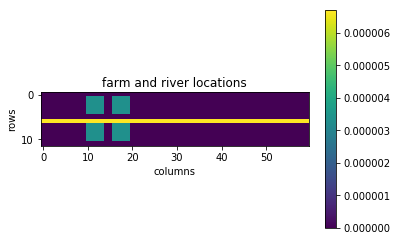

In [153]:
riv_loc2d = (riv_loc[1],riv_loc[2])
surface = farm_rech
surface[riv_loc2d] = np.max(farm_rech)*2
plt.imshow(surface)
plt.title('farm and river locations')
plt.xlabel('columns')
plt.ylabel('rows')
plt.colorbar()


### Notes on Farm fields
North Marina Area: 
Fields can be as close as 400m from the coast!! Others closer to 1.7km

Most fields are about 200x200m, some fields that appear to be row crops (strawberry? lettuce?) are 100x100 or so

Fields are in a 3 distinct patches, each patch is almost completely covered with crops:

-Near coast (400m+), verdant larger plots.

-1.7km inland, pale colored, tight rows

-2.75km inland, larger plots, varied color


Salinas Valley:
Most fields are about 200-250m wide minimum and can be 300-600m long


In [154]:
#Output control
oc_data = {}
for kper in range(nper):
    oc_data[(kper,0)] = ['save head','save budget']

In [155]:
#Create instances in flopy
bas = flopy.modflow.ModflowBas(m, ibound, strt=strt)
if bc_ocean=='CHD' or bc_inland=='CHD' :
    chd = flopy.modflow.ModflowChd(m, stress_period_data=chd_data)
if bc_ocean=='GHB' or bc_inland=='GHB'or bc_right_edge=='GHB':
    ghb = flopy.modflow.ModflowGhb(m, stress_period_data=ghb_data)
wel = flopy.modflow.ModflowWel(m, stress_period_data=wel_data, ipakcb=ipakcb)
rch = flopy.modflow.ModflowRch(m, rech=rech_data)
#riv = flopy.modflow.ModflowRiv(m, stress_period_data=riv_data)

# Add LPF package to the MODFLOW model
lpf = flopy.modflow.ModflowLpf(m, hk=hk, vka=vka, ipakcb=ipakcb,laytyp=1)

# Add PCG Package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(m, hclose=1.e-8)

# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(m,
                             stress_period_data=oc_data,
                             compact=True)

#Create the basic MT3DMS model structure
btn = flopy.mt3d.Mt3dBtn(m, 
                         laycon=lpf.laytyp, htop=henry_top, 
                         dz=dis.thickness.get_value(), prsity=0.2, icbund=icbund,
                         sconc=sconc, nprs=1,timprs=timprs)
adv = flopy.mt3d.Mt3dAdv(m, mixelm=-1)
dsp = flopy.mt3d.Mt3dDsp(m, al=al, dmcoef=dmcoef)
gcg = flopy.mt3d.Mt3dGcg(m, iter1=50, mxiter=1, isolve=1, cclose=1e-5)
ssm = flopy.mt3d.Mt3dSsm(m, stress_period_data=ssm_data)

#vdf = flopy.seawat.SeawatVdf(m, iwtable=0, densemin=0, densemax=0,denseref=1000., denseslp=0.7143, firstdt=1e-3)
vdf = flopy.seawat.SeawatVdf(m, mtdnconc=1, mfnadvfd=1, nswtcpl=0, iwtable=1, 
                             densemin=0., densemax=0., denseslp=denseslp, denseref=densefresh)


adding Package:  BAS6
adding Package:  GHB
Adding homogenous.cbc (unit=53) to the output list.
adding Package:  WEL
adding Package:  RCH
adding Package:  LPF
adding Package:  PCG
Adding homogenous.hds (unit=51) to the output list.
adding Package:  OC
adding Package:  BTN
adding Package:  ADV
adding Package:  DSP
adding Package:  GCG
found 'rch' in modflow model, resetting crch to 0.0
adding Package:  SSM
adding Package:  VDF


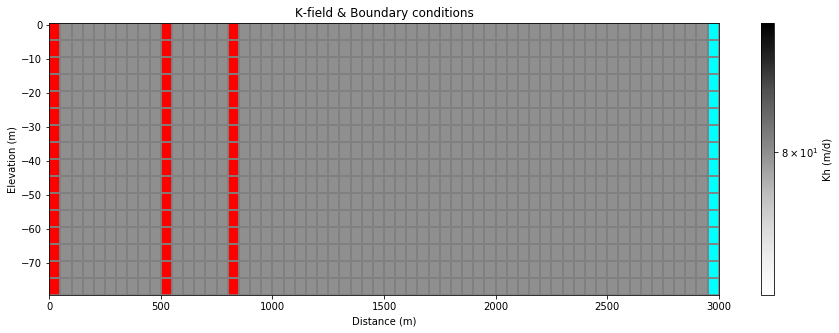

In [156]:
printyn = 0
gridon=1
rowslice=farm_orig[0][0]
m.plot_hk_ibound(rowslice=rowslice,printyn=printyn,gridon=gridon);


In [157]:
#Write input
m.write_input()

# Try to delete the output files, to prevent accidental use of older files
try:
    os.remove(os.path.join(model_ws,'MT3D.CNF'))
    os.remove(os.path.join(model_ws,'MT3D001.MAS'))
    os.remove(os.path.join(model_ws, 'MT3D001.UCN'))
    os.remove(os.path.join(model_ws, modelname + '.hds'))
    os.remove(os.path.join(model_ws, modelname + '.cbc'))
except:
    pass


Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  GHB
   Package:  WEL
   Package:  RCH
Util2d rech_1: locat is None, but model does not support free format and how is internal...resetting how = external
Util2d rech_2: locat is None, but model does not support free format and how is internal...resetting how = external
Util2d rech_3: locat is None, but model does not support free format and how is internal...resetting how = external
Util2d rech_4: locat is None, but model does not support free format and how is internal...resetting how = external
Util2d rech_5: locat is None, but model does not support free format and how is internal...resetting how = external
Util2d rech_6: locat is None, but model does not support free format and how is internal...resetting how = external
Util2d rech_7: locat is None, but model does not support free format and how is internal...resetting how = external
Util2d rech_8: locat is None, but model does not support free format and how is int

In [158]:
#Run model
import datetime
ts = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')
v = m.run_model(silent=False, report=True)
for idx in range(-3, 0):
    print(v[1][idx])

FloPy is using the following  executable to run the model: /Users/ianpg/Documents/ProjectsLocal/SyntheticSWI/bin/modflow_macOS/swt_v4

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006                      


 This program is public domain and is released on the
 condition that neither the U.S. Geological Survey nor
 the United States Government may be held liable for any
 damages resulting from their authorized or unauthorized
 use.


 Using NAME file: homogenous.nam                                                                                                                                                                                          
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/12/20 11:10

## Post-processing results

In [159]:
#Post-processing functions
def plotdischarge(modelname,model_ws,color='w',per=-1,scale=50,rowslice=0):
    fname = os.path.join(model_ws, '' + modelname + '.cbc')
    budobj = flopy.utils.CellBudgetFile(fname)
    qx = budobj.get_data(text='FLOW RIGHT FACE')[per]
    qz = budobj.get_data(text='FLOW LOWER FACE')[per]
    
    # Average flows to cell centers
    qx_avg = np.empty(qx.shape, dtype=qx.dtype)
    qx_avg[:, :, 1:] = 0.5 * (qx[:, :, 0:ncol-1] + qx[:, :, 1:ncol])
    qx_avg[:, :, 0] = 0.5 * qx[:, :, 0]
    qz_avg = np.empty(qz.shape, dtype=qz.dtype)
    qz_avg[1:, :, :] = 0.5 * (qz[0:nlay-1, :, :] + qz[1:nlay, :, :])
    qz_avg[0, :, :] = 0.5 * qz[0, :, :]
    
    y, x, z = dis.get_node_coordinates()
    X, Z = np.meshgrid(x, z[:, 0, 0])
    iskip = 1 #how many cells to skip, 1 means plot every cell
    
    ax = plt.gca()
    cpatchcollection = ax.quiver(X[::iskip, ::iskip], Z[::iskip, ::iskip],
              qx_avg[::iskip, rowslice, ::iskip], -qz_avg[::iskip, rowslice, ::iskip],
              color=color, scale=scale, headwidth=4, headlength=2,
              headaxislength=1, width=0.0025)
    return cpatchcollection

def permute_kstpkper(ucnobj):
    kstpkper = ucnobj.get_kstpkper()
    kstpkper_unique = []
    index_unique = []
    niter = 0
    for entry in kstpkper:
        if not entry in kstpkper_unique:
            kstpkper_unique.append(entry)
            index_unique.append(niter)
        niter += 1
    return kstpkper_unique, index_unique

def kstpkper_from_time(ucnobj,tottim):
    kstpkpers = ucnobj.get_kstpkper()
    times = ucnobj.get_times()
    timeind = times.index(tottim)    
    kstpkper = kstpkpers[timeind]
    return kstpkper

def kstpkper_ind_from_kstpkper(ucnobj,kstpkper=(0,0)):
    kstpkpers = ucnobj.get_kstpkper()
    kstpkper_unique = permute_kstpkper(ucnobj)[0]
    kstpkper_ind = kstpkper_unique.index(kstpkper)
    return kstpkper_ind

def get_salt_outflow(m,kstpkper=None,totim=None):
    fname = os.path.join(m.model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.binaryfile.UcnFile(fname)
    totim = ucnobj.get_times()[-1]
    if kstpkper==None:
        kstpkper = ucnobj.get_kstpkper()[-1]
    ocean_conc = ucnobj.get_data(kstpkper=kstpkper)
    return ocean_conc
    
def plot_background(mm,array,label=None):
    if label==None:
        label = [k for k,v in globals().items() if v is array][-1]
    if label=='hk':
        norm=matplotlib.colors.LogNorm()
        vmin=hkClay
        vmax=hkSand
        cmap='jet'
    else:
        norm = None
        vmin=None
        vmax=None
        cmap='jet'
    cpatchcollection = mm.plot_array(array,cmap=cmap,norm=norm,vmin=vmin,vmax=vmax)
    cpatchcollection.set_label(label)
    return cpatchcollection,label

def plot_mas(m):
    # Load the mas file and make a plot of total mass in aquifer versus time
    fname = os.path.join(m.model_ws, 'MT3D001.MAS')
    mas = flopy.mt3d.Mt3dms.load_mas(fname)
    f = plt.figure()
    ax = f.add_subplot(1, 1, 1)
    plt.xlabel('Time (d)')
    plt.ylabel('Mass (kg)')
    plt.title('Mass of salt within model through time')
    lines = ax.plot(mas.time, mas.total_mass)
    plt.show()
    return mas

In [160]:
# Extract final timestep heads
ind = -1
fname = os.path.join(model_ws, '' + modelname + '.hds')
hdobj = flopy.utils.binaryfile.HeadFile(fname)
times = hdobj.get_times()
print('Head object kstpkper:',hdobj.get_kstpkper())
hds = hdobj.get_data(totim=times[ind])
hds[np.where(ibound != 1)] = np.nan

# Extract final timestep salinity
fname = os.path.join(model_ws, 'MT3D001.UCN')
ucnobj = flopy.utils.binaryfile.UcnFile(fname)
times = ucnobj.get_times()
kstpkper = ucnobj.get_kstpkper()
conc = ucnobj.get_data(totim=times[ind])
conc[np.where(ibound != 1)] = np.nan

Head object kstpkper: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (0, 59), (0, 60), (0, 61), (0, 62), (0, 63), (0, 64), (0, 65), (0, 66), (0, 67), (0, 68), (0, 69), (0, 70), (0, 71), (0, 72), (0, 73), (0, 74), (0, 75), (0, 76), (0, 77), (0, 78), (0, 79)]


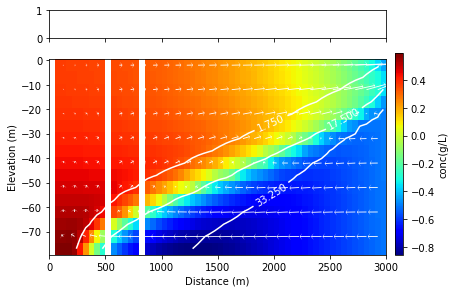

In [161]:
# Make head and quiver plot
import utils
printyn = 1
rowslice = riv_loc[1][0]
rowslice = farm_orig[0][0]
per= -2

f, axs = plt.subplots(2,1, sharex=True, figsize=(6, 4),
                     gridspec_kw = {'height_ratios':[1, 7]})
plt.tight_layout()

#Plot discharge and ibound
plt.sca(axs[1]) #set current axes
mm = flopy.plot.ModelCrossSection(ax=axs[1], model=m, line={'row':rowslice})

#Plot background
backgroundpatch,lbl = cpatchcollection,label = plot_background(mm,hds,'conc(g/L)')
lvls = Cfresh + (Csalt-Cfresh)*np.array([.05,.5,.95])
CS = mm.contour_array(conc,head=hds,levels=lvls,colors='white')
plt.clabel(CS, CS.levels, inline=True, fontsize=10)

#mm.contour_array(hds,head=hds)
mm.plot_ibound()
mm.plot_bc(ftype='WEL',color='white')
#Plot discharge
utils.plotdischarge(m,color='white',per=per,scale=150,rowslice=rowslice,iskip=2);
plt.xlabel('Distance (m)')
plt.ylabel('Elevation (m)')
plt.subplots_adjust(bottom=.1)

'''
#plot SGD
ocean_flow = 100 * np.asarray(utils.get_ocean_outflow_chd(m,ocean_bool=ocean_line_tuple))
plt.sca(axs[0]) #set current axes
#plt.bar(np.arange(ocean_col[0],ocean_col[1]+1)+delc/2,
#        ocean_flow[:,rowslice,:][ocean_bool[:,rowslice,:]])
rowslice_inds = np.where(ocean_line_tuple[1]==rowslice)[0]
plt.bar(np.arange(ocean_col[0],ocean_col[1]+1)+delc/2,
        ocean_flow[(ocean_line_tuple[0][rowslice_inds],
                    ocean_line_tuple[1][rowslice_inds],
                    ocean_line_tuple[2][rowslice_inds])])
axs[0].axhline()
axs[0].set_ylim(np.min(ocean_flow),np.max(ocean_flow))
plt.ylabel('SGD (cm/d)')
axs[0].annotate('total outflow = ' + str(np.sum(ocean_flow[np.where(ocean_flow>0)])) + 
                ' cm/d \n\ntotal inflow = ' + str(np.sum(ocean_flow[np.where(ocean_flow<0)])) +
                ' cm/d', xy=(.1,.5),
                xytext=(0.1, 0.3), xycoords='axes fraction', textcoords='axes fraction')

#Plot salt content of cells beneath outflow
#ocean_below_ind = [ocean_line_tuple[0]+1, #layer below ocean
#                   ocean_line_tuple[1],
#                   ocean_line_tuple[2]]   
#ind = np.where(ocean_below_ind[1] == rowslice)
#ocean_below_ind_slice = (ocean_below_ind[0][ind],
#                         ocean_below_ind[1][ind],
#                         ocean_below_ind[2][ind])
#ocean_salt_outflow = utils.get_salt_outflow(m,kstpkper = (nstp[-1]-1,nper-1))[ocean_below_ind_slice]
                   
                   
axs02 = axs[0].twinx()
#plt.plot(ocean_col_vec[2]+delc/2 , ocean_salt_outflow,'r.')
#plt.ylabel('conc \nunderlying (g/L)',rotation=90)
'''
#align plots and set colorbar
f.subplots_adjust(left=.1,right=0.88)
cbar_ax = f.add_axes([0.90, 0.1, 0.02, 0.7])
cb = f.colorbar(cpatchcollection,cax=cbar_ax)
cb.set_label(label)
if printyn == 1:
    plt.savefig(os.path.join(m.model_ws, m.name + '_' + ts + '_flowvec_row' + str(rowslice) +
                             '_per' + str(per) + '_' + lbl[:3] + '.png'),dpi=150)
plt.show()

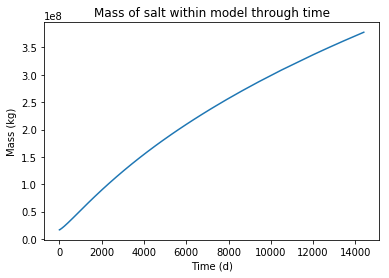

In [162]:
mas = plot_mas(m)

## MC experiment
Rerun model, select new parameter value for each input param and record.

### MC functions

In [89]:
import scipy.stats as sts

#Create new MC_file
from pathlib import Path
def create_MC_file():
    ts = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')
    MC_dir = Path(os.path.join(m.model_ws, 'MC_expt_' + ts))
    if not MC_dir.exists():
        MC_dir.mkdir()
    m.MC_file = Path(os.path.join(MC_dir,'expt.txt'))
    fout= open(m.MC_file,"w")
    fout.close()
    print(m.MC_file)
    return

def add_to_paramdict(paramdict,paramname,val):
    if paramdict is None:
        paramdict = {}
    if  paramname in list(paramdict.keys()):
        paramdict[paramname].append(val)
    else:
        #paramdict.update(paramname=[val])
        paramdict[paramname] = [val]
    return


def record_salinity(m,totim=None,fname_write=None,ts_hms=None):
    from pathlib import Path
    if ts_hms is None:
        ts_hms = datetime.datetime.now().strftime('%H-%M-%S')
    # Extract final timestep salinity
    fname = os.path.join(m.model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.binaryfile.UcnFile(fname)
    if totim is None:
        totim = ucnobj.get_times()[-1]
    conc = ucnobj.get_data(totim=totim)
    if fname_write is None:
        fname_write = m.MC_file.parent.joinpath('conc_' + str(int(totim)) + '_' + ts_hms + '.npy')
        print(fname_write)
        np.save(fname_write,conc)
    return conc

def copy_rename(old_file_name, new_file_name):
    import os
    import shutil
    src_dir= os.curdir
    dst_dir= os.path.join(os.curdir , "subfolder")
    src_file = os.path.join(src_dir, old_file_name)
    shutil.copy(src_file,dst_dir)

    dst_file = os.path.join(dst_dir, old_file_name)
    new_dst_file_name = os.path.join(dst_dir, new_file_name)
    os.rename(dst_file, new_dst_file_name)
    return
    
def reassign_m():
    #### Reassign ####
    dis = flopy.modflow.ModflowDis(m, nlay, nrow, ncol, nper=nper, delr=delr,
                                   delc=delc, xul=xul, yul=yul, rotation=rotation,
                                   laycbd=0, top=henry_top,
                                   botm=henry_botm, perlen=perlen, nstp=nstp,
                                   steady=steady,itmuni=itmuni,lenuni=lenuni,
                                   tsmult=tsmult)

    #Create instances in flopy
    bas = flopy.modflow.ModflowBas(m, ibound, strt=strt)
    if bc_ocean=='CHD' or bc_inland=='CHD' :
        chd = flopy.modflow.ModflowChd(m, stress_period_data=chd_data)
    if bc_ocean=='GHB' or bc_inland=='GHB'or bc_right_edge=='GHB':
        ghb = flopy.modflow.ModflowGhb(m, stress_period_data=ghb_data)
    if bc_ocean=='WEL' or bc_inland=='WEL':
        wel = flopy.modflow.ModflowWel(m, stress_period_data=wel_data, ipakcb=ipakcb)
    if rech_on==1:
        rch = flopy.modflow.ModflowRch(m, rech=rech_data, nrchop=1)

    # Add LPF package to the MODFLOW model
    lpf = flopy.modflow.ModflowLpf(m, hk=hk, vka=vka, ipakcb=ipakcb,laytyp=1)

    # Add PCG Package to the MODFLOW model
    pcg = flopy.modflow.ModflowPcg(m, hclose=1.e-8)

    # Add OC package to the MODFLOW model
    oc = flopy.modflow.ModflowOc(m,
                                 stress_period_data=oc_data,
                                 compact=True)

    #Create the basic MT3DMS model structure
    btn = flopy.mt3d.Mt3dBtn(m, 
                             laycon=lpf.laytyp, htop=henry_top, 
                             dz=dis.thickness.get_value(), prsity=0.2, icbund=icbund,
                             sconc=sconc, nprs=1,timprs=timprs)
    adv = flopy.mt3d.Mt3dAdv(m, mixelm=-1)
    dsp = flopy.mt3d.Mt3dDsp(m, al=al, dmcoef=dmcoef)
    gcg = flopy.mt3d.Mt3dGcg(m, iter1=50, mxiter=1, isolve=1, cclose=1e-5)
    ssm = flopy.mt3d.Mt3dSsm(m, stress_period_data=ssm_data)

    #vdf = flopy.seawat.SeawatVdf(m, iwtable=0, densemin=0, densemax=0,denseref=1000., denseslp=0.7143, firstdt=1e-3)
    vdf = flopy.seawat.SeawatVdf(m, mtdnconc=1, mfnadvfd=1, nswtcpl=0, iwtable=1, 
                                 densemin=0., densemax=0., denseslp=denseslp, denseref=densefresh)
    return

In [90]:
def get_yn_response(prompt):
    while True:
        try:
            resp = str(input(prompt))
        except ValueError:
            print("Sorry, I didn't understand that.")
            continue
        if resp[0] is 'y':
            value = True
            break
        elif resp[0] is 'n':
            value = False
            break
        else:
            print('This didnt work right. Try again')
            continue
    return value


In [91]:
print(m.MC_file,m.inputParams)

None None


In [92]:
#create_MC_file()

### Run the MC experiment:

In [102]:
from scipy.io import savemat

def run_MC(tot_it):

    #### MAKE NEW/ADD TO OLD EXPT ####
    if m.MC_file is None:
        create_MC_file()
        m.inputParams = {}
    else:
        if m.inputParams is not None:
            if len(m.inputParams)>0:
                test = get_yn_response("m.inputParams already has entries, do you want to add to it?")
                if test is True:
                    pass
                else: 
                    m.inputParams = {}
            else:
                m.inputParams = {}
        else:
            m.inputParams = {}
          
    #### VARY PARAMS ####
    it = 0
    while it < tot_it:
        it += 1
        ##hk: hk
        #      Uniform (1,100)
        low= 1e-1
        high = 100
        parname='hk'
        hk = sample_dist(sts.uniform,1,1,m,'hk',0,*(low,high-low))
        add_to_paramdict(m.inputParams,parname,hk)

        ##vka: ratio of vk/hk
        #      Uniform (1/20,1)
        low= 1/20
        high = 1
        parname='vka'
        vka = sample_dist(sts.uniform,1,1,m,'vka',0,*(low,high-low))
        add_to_paramdict(m.inputParams,parname,vka)

        ##al: #longitudinal dispersivity (m) 
        #      Uniform [0.1,20] #10 from Walther et al
        low= 0.1
        high = 20
        parname='al'
        al = sample_dist(sts.uniform,1,1,m,'al',0,*(low,high-low))
        add_to_paramdict(m.inputParams,parname,al)

        ##dmcoef: #dispersion coefficient (m2/day) 
        #      log-uniform [1e-10,1e-5] #2e-9 from Walther et al
        lowhigh = np.log10([1e-10,1e-5])
        parname='dmcoef'
        dmcoef = sample_dist(sts.uniform,1,1,m,'dmcoef',1,*(lowhigh[0],lowhigh[1]-lowhigh[0]))
        add_to_paramdict(m.inputParams,parname,dmcoef)

        ##rech
        rechargs = tuple(np.log10((1e-6/(nrow*ncol),1e-1/(nrow*ncol))))
        rechargs = (rechargs[0],rechargs[1]-rechargs[0])
        rech = sample_dist(sts.uniform,1,0,m,'rech',1,*rechargs)

        farm_rechargs = (rechargs[0],rechargs[1]) #note: this is in log space
        farm_rech_flux = sample_dist(sts.uniform,1,0,m,'rech',1,*farm_rechargs)
        farm_rech[farm_loc] = farm_rech_flux
        rech_data = {}
        for i in range(len(perlen)):
            if i%2==0:
                rech_data[i] = np.ones((nrow,ncol),dtype=np.float)*rech 
            else:
                rech_data[i] = farm_rech 
        parname = 'rech'
        add_to_paramdict(m.inputParams,parname,rech)
        parname = 'farm_rech'
        add_to_paramdict(m.inputParams,parname,farm_rech_flux)

        ##wel
        lowhigh = np.log10((1e1,1e3))
        wel_flux = sample_dist(sts.uniform,n_wells,0,m,'wel',1,*(lowhigh[0],lowhigh[1]-lowhigh[0]))
        parname = 'wel'
        for i in range(n_wells):
            parname_temp = parname+str(i)
            add_to_paramdict(m.inputParams,parname_temp,wel_flux[i])    
        #write wel data
        wel_data,ssm_data = add_pumping_wells(wel_data_base,ssm_data_base,n_wells,wel_flux,farm_orig,kper_odd)    

        ##riv_stg
        parname = 'riv_stg'
        lowhigh = (rbot,henry_top)
        stage = sample_dist(sts.uniform,1,0,m,'riv_stg',0,*(lowhigh[0],lowhigh[1]-lowhigh[0]))
        add_to_paramdict(m.inputParams,parname,stage)
        
        ##riv_cond
        parname = 'riv_cond'
        lowhigh = np.log10((.1,100))
        cond = sample_dist(sts.uniform,1,0,m,'riv_cond',1,*(lowhigh[0],lowhigh[1]-lowhigh[0]))
        add_to_paramdict(m.inputParams,parname,cond)
        #Write river data--take SSM data from WEL!!
        riv_data,ssm_data = write_river_data(riv_loc,stage,cond,rbot,kper_odd,ssm_data)
            
            
        ###### Reassign, run record ######
        #Reassign to model object
        reassign_m()

        #Write input
        m.write_input()

        # Try to delete the output files, to prevent accidental use of older files
        flist = [os.path.join(model_ws,'MT3D.CNF'),
                  os.path.join(model_ws,'MT3D001.MAS'),
                  os.path.join(model_ws, modelname + '.hds'),
                  os.path.join(model_ws, 'MT3D001.UCN'),
                  os.path.join(model_ws, 'MT3D001.UCN'),
                  os.path.join(model_ws, modelname + '.cbc')]
        for f in flist:
            try:
                os.remove(f)
            except:
                pass
        '''
        try:
            os.remove(os.path.join(model_ws,'MT3D.CNF'))
            os.remove(os.path.join(model_ws,'MT3D001.MAS'))
            os.remove(os.path.join(model_ws, modelname + '.hds'))
        except:
            pass

        try:
            os.remove(os.path.join(model_ws, 'MT3D001.UCN'))
        except:
            pass

        try:
            os.remove(os.path.join(model_ws, modelname + '.cbc')) 
        except:
            pass
        '''

        #Make timestamp
        import datetime
        sep = '-'
        ts = datetime.datetime.now().strftime('%m'+sep+'%d'+sep+'%H'+sep+'%M'+sep+'%S')
        ts_hms = ts.split(sep)[2:]
        ts_hms = sep.join(ts_hms)

        #Run model
        v = m.run_model(silent=True, report=True)
        for idx in range(-3, 0):
            print(v[1][idx])


        #Record final salinity as .npy, also move full CBC and UCN files to expt folder
        _ = record_salinity(m,ts_hms=ts_hms);
        copy_rename(os.path.join(m.model_ws,'MT3D001.UCN'),m.MC_file.parent.joinpath('conc_'+ts_hms+'.UCN').as_posix())
        #copy_rename(os.path.join(m.model_ws,m.name+'.cbc'),m.MC_file.parent.joinpath('cbc_'+ts_hms+'.cbc').as_posix())

        print('Finished iteration ',it,'out of ',tot_it)
    #Save inputParams immediately to prevent accidental destruction of them
    savemat(m.MC_file.parent.joinpath('inputParams.mat').as_posix(),m.inputParams)
    return inputParams

In [113]:
####Run the MC experiment ####
tot_it = 10



inputParams = run_MC(tot_it)

####Run the MC experiment ####

m.inputParams already has entries, do you want to add to it?y
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfdis.ModflowDis'> <class 'flopy.modflow.mfdis.ModflowDis'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfghb.ModflowGhb'> <class 'flopy.modflow.mfghb.ModflowGhb'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfwel.ModflowWel'> <class 'flopy.modflow.mfwel.ModflowWel'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mfrch.ModflowRch'> <class 'flopy.modflow.mfrch.ModflowRch'>
replacing existing Package...
****Warning -- two packages of the same type:  <class 'flopy.modflow.mflpf.ModflowLpf'> <class 'flopy.modflow.mflpf.ModflowLpf'>
replacing exis

IndexError: index 0 is out of bounds for axis 0 with size 0

In [24]:
'''
    ## Add well data
    parname = 'wel'
    lowhigh = np.log10((1e1,1e2))
    wel_flux = sample_dist(sts.uniform,n_wells,0,m,'wel',1,*(lowhigh[0],lowhigh[1]-lowhigh[0]))
    wel_data,ssm_data = add_pumping_wells(wel_data_base,ssm_data_base,n_wells,wel_flux,farm_orig,kper_odd)    
    for i in range(n_wells):
        parname_temp = parname+i
        add_to_paramdict(inputParams,parname_temp,wel_flux[i])
    
    ##rech: surface recharge
    # log-uniform (1e-7,1e-3)
    lowhigh = np.log10([1e-7/(nrow*ncol),1e-1/(nrow*ncol)])
    parname = 'rech'
    rech_data = sample_dist(sts.uniform,1,1,m,'rech',1,*(lowhigh[0],lowhigh[1]-lowhigh[0]))
    add_to_paramdict(inputParams,parname,rech_data)
    
    #### ADD WELL DATA####
    ##wel_data: #well pumping (m/day)
    #      Uniform (1e-2,1e1)
    lowhigh = np.log10([1e-2,1e1])
    n_wells = 2
    rowcol = [(int(m.nrow/2),int(m.ncol/2)), #location of wells set
             (int(m.nrow/3),int(m.ncol/3))]
    args = (sts.uniform,1,0,m,'wel',1,*(lowhigh[0],lowhigh[1]-lowhigh[0]))
    wel_data,ssm_data,flx = add_pumping_wells(wel_data_base,ssm_data_base,n_wells,sample_dist,rowcol,*args)
    write_sample(m.MC_file,'wel',sts.uniform,flx)
    add_to_paramdict(inputParams,'wel1',flx[0])
    add_to_paramdict(inputParams,'wel2',flx[1])
'''

### Load data, calc Hausdorff distance matrix

In [114]:
import pandas
inputDF = pandas.DataFrame(m.inputParams)
inputDF

,al,dmcoef,farm_rech,hk,rech,riv_cond,riv_stg,vka,wel0,wel1,wel2,wel3
0,10.913435,3.930528e-06,8.508278e-08,36.526700,2.670342e-08,5.768863,-1.875777,0.401683,62.554071,71.545021,52.020989,22.741285
1,19.590045,2.869758e-09,3.197758e-09,35.959933,5.876120e-07,32.843521,-3.974567,0.217775,13.988806,13.826117,20.111848,71.385730
2,2.026623,7.560112e-10,2.553080e-05,74.116007,1.076608e-06,0.288796,-3.587652,0.832915,66.451757,319.801129,300.066612,320.304550
3,3.284789,8.831733e-06,6.400694e-07,48.813851,4.712681e-08,0.121565,-3.020345,0.844458,461.007194,20.706166,878.656416,65.280758
4,5.180628,6.275370e-08,1.493865e-06,49.630881,3.728182e-06,71.571801,-2.644078,0.174664,33.286500,49.857819,45.932885,167.418047
5,16.299616,5.336468e-07,9.345634e-08,72.196700,5.068184e-08,2.135961,-0.609247,0.123483,169.672688,333.916455,10.136704,136.111588
6,1.988436,5.903070e-09,6.169841e-07,98.981338,9.542367e-05,21.825899,-2.159479,0.975360,102.880302,12.911203,822.556066,23.363866
7,1.760714,1.076333e-10,4.063026e-05,24.282800,3.110995e-06,28.725625,-2.276745,0.098266,110.190055,34.478577,18.082616,453.223563
8,14.453065,4.444337e-08,4.792274e-09,40.370566,1.543947e-07,3.696147,-2.315053,0.827263,197.566614,10.172123,92.593750,16.066708
9,19.829119,6.660771e-09,4.058256e-05,72.936749,5.836000e-05,9.624066,-3.796932,0.182180,27.655969,14.848581,617.699986,113.381372


In [115]:
import glob
saveyn=1

def mod_hausdorff(u,v):
    from scipy.spatial.distance import directed_hausdorff
    return max(directed_hausdorff(u,v)[0], directed_hausdorff(v,u)[0])

#make a point cloud for each conc array
conc_fnames = glob.glob(m.MC_file.parent.joinpath('conc*.npy').as_posix())        
        
pct50 = (Csalt+Cfresh)/2
tol = .20 #percentage
conc_mat = np.zeros((len(conc_fnames),nlay,nrow,ncol),dtype=float)

idx_dict = {}
for i,fname in enumerate(conc_fnames):
    conc_mat[i] = np.load(fname)
    idx_dict[i] = np.where((conc_mat[i]<pct50*(1+tol)) & (conc_mat[i]>pct50*(1-tol)))

#Filter out keys that are empty and make new dict with filled sequential keys
filt = [k for k, v in idx_dict.items() if len(v[0])==0]
i=0
idx_dict_filt = {}
for k,v in idx_dict.items():
    if k in filt:
        print('iteration ',k,'is empty and will be filtered out')
    else:
        idx_dict_filt[i] = v
        i+=1  

#Do the same with inputParams dictionary
i=0
inputParams_filt = {}
for k,v in m.inputParams.items():
    vnew = [x for i, x in enumerate(v) if i not in filt]
    inputParams_filt[k] = vnew
    if i==0:
        N = len(vnew)
    i+=1

#Calc modified hausdorff matrix
#idx_dict = {k: v for k, v in idx_dict.items() if len(v[0])!=0} #Filter out empty keys. Might want to tie this to the pertinent files
hdorf_mat = np.zeros((len(idx_dict_filt),len(idx_dict_filt)),dtype=float)
for i in range(len(idx_dict_filt)):
    for j in range(i+1,len(idx_dict_filt)):
        hdorf_mat[i,j] = mod_hausdorff(idx_dict_filt[j],idx_dict_filt[i])
hdorf_mat = hdorf_mat + hdorf_mat.T
#Save hausdorff matrix, Input Parameter Values
ParametersValues = np.zeros((N,len(inputParams_filt)))
for i,key in enumerate(inputParams_filt):
    ParametersValues[:,i] = np.asarray(inputParams_filt[key])

if saveyn==1:
    hdorf_matdict = {}
    hdorf_matdict['hausdorff_mat'] = hdorf_mat
    hdorf_matdict['InputParams'] = inputParams_filt #Dict of the names and values, mostly for error checking
    hdorf_matdict['ParametersValues'] = ParametersValues
    np.save(m.MC_file.parent.joinpath('hausdorff.npy'),hdorf_mat)
    savemat(m.MC_file.parent.joinpath('hausdorff.mat').as_posix(),hdorf_matdict)

['hk', 'vka', 'al', 'dmcoef', 'rech', 'farm_rech', 'wel0', 'wel1', 'wel2', 'wel3', 'riv_stg', 'riv_cond']


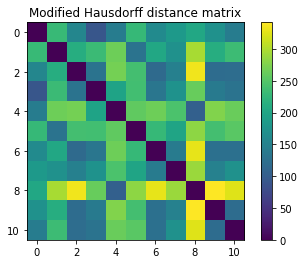

In [116]:
import matplotlib.pyplot as plt
plt.imshow(hdorf_mat);plt.colorbar()
plt.title('Modified Hausdorff distance matrix')
print(list(m.inputParams.keys()))

In [117]:
m.MC_file

PosixPath('/Users/ianpg/Documents/ProjectsLocal/DelawareSGD/work/homogenous/MC_expt_2018-12-20-00-41/expt.txt')

In [118]:
print(Lx,Ly,Lz)

3000.0 600.0 80.0


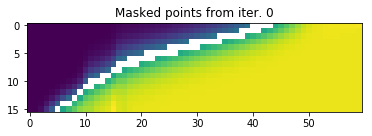

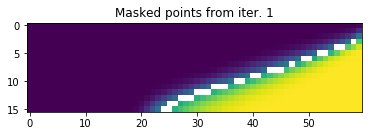

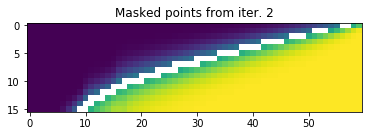

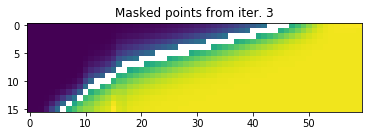

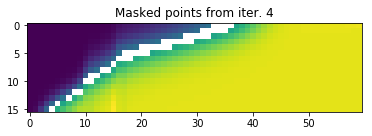

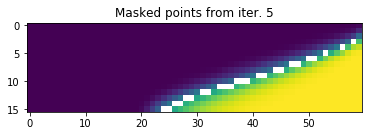

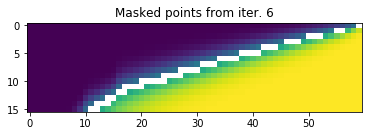

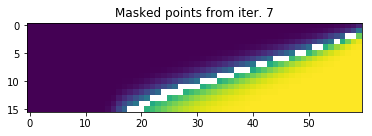

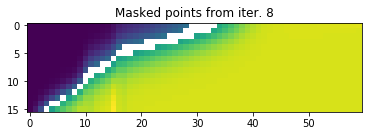

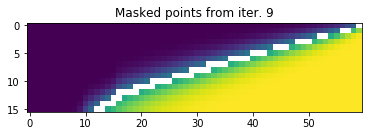

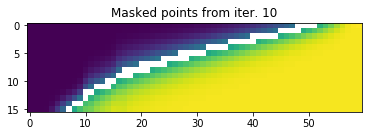

In [119]:
import numpy.ma as ma
pctage = np.array([.05,.5,.95])
pctage = np.array([.5])
salthresh = Cfresh + (Csalt-Cfresh)*pctage #salinity corresponding to the spec. percentage
tol = [.3,.2,.03]
tol = [.2]
for i in range(conc_mat.shape[0]):
    if i>12:
        break
    for k in range(len(pctage)):
        plt.figure()
        mskd = ma.masked_where((conc_mat[i]<salthresh[k]*(1+tol[k])) & 
                               (conc_mat[i]>salthresh[k]*(1-tol[k])),conc_mat[i])
        plt.imshow(mskd[:,farm_orig[1][0],:])
        plt.title('Masked points from iter. ' + str(i))

In [91]:
#Might want to add points along the base and right edge of the model, to make sure that
#mod hausdorff dist. is taking distance into account
conc=conc_mat[0]
pctage = .5
salthresh = Cfresh + (Csalt-Cfresh)*pctage
tol=.2

ind1 = np.where((conc<salthresh*(1+tol)) & (conc>salthresh*(1-tol)),1,0)
ind2 = get_line((nlay-1,int(ncol/2)),(nlay-1,ncol-1),allrows=1,nrow=nrow)
ind2 = tuple(np.array(ind2).T) #use this for indexing numpy arrays


NameError: name 'conc_mat' is not defined

# Reading in real data

In [452]:
import pandas
from pathlib import Path
ws = Path(m.model_ws)
basedir = ws.joinpath('..','..')
datadir = basedir.joinpath('data')
fname = datadir.joinpath('seepage_flow_2015.xlsx')
flowsheet = pandas.read_excel(fname,skiprows=1)
print('Columns: ',flowsheet.columns)

Columns:  Index(['Row', 'Column', 'X', 'Y', 'Z', 'MeterNo', 'Flow', 'EC_IN', 'pctFW',
       'FlowFW', 'FlowSW'],
      dtype='object')


cmap='jet'

plt.scatter(flowsheet.X,flowsheet.Y,s=flowsheet.Flow,c=100-flowsheet.pctFW,cmap=cmap,vmin=0,vmax=100)


printyn = 0
layer= 1
cmap='jet'
f = plt.figure(figsize=(4, 10))
ax = plt.subplot()
ax.set_xlabel('X UTM (m)')
ax.set_ylabel('Y UTM (m)')
modmap = flopy.plot.ModelMap(model=m,ax=ax,rotation=rotation,xul=xul,yul=yul,layer=layer)

modmap.plot_ibound()
ax.set_aspect('equal')
scat = plt.scatter(flowsheet.X,flowsheet.Y,c=100-flowsheet.pctFW,cmap=cmap,vmin=0,vmax=100)
#cpatchcollection = modmap.plot_array(conc,cmap=cmap)
cb= f.colorbar(scat)
#cb.set_label('Concentration (g/L)')
cb.set_label('Pct Saltwater')

if printyn == 1:
    plt.savefig(os.path.join(m.model_ws, m.name + '_topview_lay ' + str(layer) +
                             '_per' + str(per) + '.png'),dpi=300)
plt.show()

#Issue: which "flow" is the correct flow?
    #Can get flow from the cell-by-cell file in either FLOW RIGHT FACE and FLOW LOWER FACE
    # Or from the constant head flow

ocean_flow = get_ocean_outflow(m,ocean_col);
print('total flow into ocean cells from const. head flow:',-np.sum(ocean_flow),'m^3/d')

fname = os.path.join(model_ws, '' + modelname + '.cbc')
budobj = flopy.utils.CellBudgetFile(fname)
qx = budobj.get_data(text='FLOW RIGHT FACE')[-1]
qz = budobj.get_data(text='FLOW LOWER FACE')[-1]
tot_flow = np.sum( np.sqrt(np.square(-qz[ocean_coords]) + np.square(qx[ocean_coords])))
print('Total flow from lower-right face in cbc file', tot_flow ,'m^3/d' )

In [453]:
lvls = (Csalt-Cfresh)*np.array([.05,.5,.95]) + Cfresh

indtop = np.where(verts[:,0] > botm_vector[0])[0]
indbot = np.where(verts[:,0] < botm_vector[-2])[0]
inds = np.hstack((indtop,indbot))


p = CS.collections[2].get_paths()[0]
v = p.vertices
x = v[:,0]
y = v[:,1]
plt.scatter(x,y)
plt.scatter(verts[inds][:,2],verts[inds][:,0])
plt.axis('equal')

def extract_contourpoints_2d(np_array,levels):
    if len(np_array.shape) == 2:
        CS = plt.contour(array,levels=lvls);
    elif len(np_array.shape) > 2:
        pass
        #do something
    return
print(x[0],x[-1])
print(y[0],y[-1])

print(verts[indtop])
print(verts[indbot])



NameError: name 'verts' is not defined

In [ ]:
def keep_running(m,new_perlen):
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.binaryfile.UcnFile(fname)
    conc = ucnobj.get_data(totim=ucnobj.get_times()[-1])
    new_sconc = np.abs(np.round(conc,decimals=1))
    new_sconc[ocean_line_tuple] = Csalt
    new_sconc[right_edge] = Csalt
    new_sconc[:,:,0] = Cfresh
    new_sconc[np.isnan(new_sconc)] = 0.
    # Add DIS package to the MODFLOW model
    dis = flopy.modflow.ModflowDis(m, nlay, nrow, ncol, nper=nper, delr=delr,
                                   delc=delc, xul=xul, yul=yul, rotation=rotation,
                                   laycbd=0, top=henry_top,
                                   botm=henry_botm, perlen=new_perlen, nstp=nstp,
                                   steady=steady,itmuni=itmuni,lenuni=lenuni,
                                   tsmult=tsmult)

    #Create the basic MT3DMS model structure
    btn = flopy.mt3d.Mt3dBtn(m, 
                             laycon=lpf.laytyp, htop=henry_top, 
                             dz=dis.thickness.get_value(), prsity=0.2, icbund=icbund,
                             sconc=new_sconc)
    #Write input
    m.write_input()
    # Try to delete the output files, to prevent accidental use of older files
    try:
        os.remove(os.path.join(model_ws,'MT3D.CNF'))
        os.remove(os.path.join(model_ws,'MT3D001.MAS'))
        os.remove(os.path.join(model_ws, 'MT3D001.UCN'))
        os.remove(os.path.join(model_ws, modelname + '.hds'))
        os.remove(os.path.join(model_ws, modelname + '.cbc'))
    except:
        pass
    m.run_model()
    return

In [ ]:
keep_running(m,[1000,1000,1000])

In [ ]:
import numpy as np
from numpy import sin, cos, pi
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

verts, faces, norms, vals = measure.marching_cubes(conc, level=lvls[1], spacing=(-delv, delc, delr))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(verts[:, 2], verts[:,1], faces, verts[:, 0],
                cmap='Spectral', lw=1)
plt.xlabel('Distance (m) columns')
plt.ylabel('Distance (m) rows')
plt.show()

In [472]:
#Functions for extracting 'return variables' from data
def get_inds(verts,botm_vector):
    indtop = np.where(verts[:,0] > botm_vector[0])[0]
    indbot = np.where(verts[:,0] < botm_vector[-2])[0]
    return indtop,indbot

def get_angles(verts,norms,botm_vector):
    #takes the verts and norms arrays that are outputs of 
    #skimage.measure.marching_cubes()
    #Returns:
    #   theta_top:  avg angle between horizontal and topmost (tip) values
    #   theta_botm: avg angle between horizontal and bottommost (toe) values
    #   theta_avg:  avg angle between toe and tip. Defined as theta in Badaruddin et al., 2017
    indtop,indbot = get_inds(verts,botm_vector)
    horznorm = [1,0,0] #in lay,row,col format i.e. z,y,x
    theta_top = np.mean(np.arccos(np.dot(norms[indtop],horznorm)))
    theta_botm = np.mean(np.arccos(np.dot(norms[indbot],horznorm)))
    theta_avg = np.arctan(
        (np.mean(verts[indtop][:,0]) - np.mean(verts[indbot][:,0]))
        /(np.mean(verts[indtop][:,2]) - np.mean(verts[indbot][:,2])))
    return [theta_top,theta_botm,theta_avg]

def get_avg_width_dist(array, lvls, spacing=None):
    #calls the function skimage.measure.marching_cubes()
    #to retrieve estimates on transition zone parameters
    #returns np.nan if the value cannot be calculated because the contour hits the edge of model
    #Input arguments:
    #   array: 3-d array to be contoured
    #   lvls: list of length 2, used for contouring. Should be in ascending order!
    #   spacing: tuple of the spacing of input array, i.e. (delv,delc,delr) for MODFLOW arrays
    #Returns:
    #   width_tip_avg: avg topmost width between the two values in lvls
    #   width_toe_avg: avg bottommost width between the two values in lvls
    #   xtip_avg:      avg topmost x-position of the first input of lvls in dimensions of the array  
    #   xtoe_avg:      avg bottommost x-position of the first input of lvls in dimensions of the array  
    if spacing is None:
        spacing = (-delv, delc, delr)
    indtop_all,indbot_all = [],[]
    verts,faces,norms,vals = {},{},{},{}
    for i,lvl in enumerate(lvls):
        verts[i], faces[i], norms[i], vals[i] = measure.marching_cubes(conc, level=lvl, spacing=spacing)
        indtop,indbot = get_inds(verts[i],botm_vector)
        indtop_all.append(indtop)
        indbot_all.append(indbot)
    test_bot = [indarray.size for indarray in indbot_all]
    test_top = [indarray.size for indarray in indtop_all]
    if 0 in test_top:
        warnings.warn('\n -->Full tip not within model. Placing nan as stand-in<---')
        width_tip_avg = np.nan
    else:
        width_tip_avg = np.mean(verts[1][indtop_all[1]] - verts[0][indtop_all[0]],axis=0)[2]
    
    if 0 in test_bot:
        warnings.warn('\n -->Full toe not within model. Placing nan as stand-in<---')
        width_toe_avg = np.nan
    else:
        width_toe_avg = np.mean(verts[1][indbot_all[1]] - verts[0][indbot_all[0]],axis=0)[2]

    if test_bot[0]==0:
        warnings.warn('\n -->Toe x-pos not within model. Placing nan as stand-in<---')
        xtoe_avg = np.nan
    else:
        xtoe_avg = np.mean(verts[0][indbot_all[0]],axis=0)[2]
        
    if test_top[0]==0:
        warnings.warn('\n -->Tip x-pos not within model. Placing nan as stand-in<---')
        xtip_avg = np.nan
    else:
        xtip_avg = np.mean(verts[0][indtop_all[0]],axis=0)[2]
        
    return width_tip_avg,width_toe_avg,xtip_avg,xtoe_avg